<a href="https://colab.research.google.com/github/aks2093/StackExchange-Question-Tags-Prediction/blob/master/StackExachange_tags_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Necessary Libraries 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from bs4 import BeautifulSoup
from keras import backend as K
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import os
import string
from sklearn.utils import shuffle
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import math
import statistics
import tensorflow
from tensorflow.keras.layers import Dense, Embedding, Dropout, Flatten, Input, LSTM, Convolution1D, MaxPooling1D
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, PReLU, Activation
import collections
from pprint import pprint


Using TensorFlow backend.


# Import nltk 

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Define Utility Functions and variables/objects

In [ ]:
# DATA_DIR = r"C:\Users\amis\PycharmProjects\stackexchange_tags\data"
DATA_DIR = "/content/drive/My Drive/stackExchange_tag_predictions/data"


lemma=WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

# Parse html
def parse_html(data):
    soup = BeautifulSoup(data, 'html.parser')
    soup = soup.get_text()
    soup = BeautifulSoup(soup, 'html.parser')
    soup = soup.decode('utf8')
    text = soup.replace('\n', ' ')
    return text

#lammatize the feature texts
def lemmatization(text):
    words = word_tokenize(text)
    listLemma = []
    for w in words:
        x = lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))


#Function to remove stopwords from feature texts
def stopWordsRemove(text):
    stop_words = set(stopwords.words("english"))
    words = word_tokenize(text)
    filtered = [w for w in words if not w in stop_words]
    return ' '.join(map(str, filtered))



# Evaluation Metrics(Micro F1 Score, Jaccard_Distance, Hamming_Loss)

In [ ]:
def micro_f1_score(y_true, y_pred, threshold=None):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    if threshold is None:
        threshold = tensorflow.reduce_max(y_pred, axis=-1, keepdims=True)
        y_pred = tensorflow.logical_and(y_pred >= threshold, tensorflow.abs(y_pred) > 1e-12)
    else:
        y_pred = y_pred > threshold
    
    y_true = tensorflow.cast(y_true, tensorflow.float32)
    y_pred = tensorflow.cast(y_pred, tensorflow.float32)

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def jaccard_distance(y_true, y_pred, threshold=None, smooth=100):
    if threshold is None:
        threshold = tensorflow.reduce_max(y_pred, axis=-1, keepdims=True)
        y_pred = tensorflow.logical_and(y_pred >= threshold, tensorflow.abs(y_pred) > 1e-12)
    else:
        y_pred = y_pred > threshold
    
    y_true = tensorflow.cast(y_true, tensorflow.int32)
    y_pred = tensorflow.cast(y_pred, tensorflow.int32)

    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

def hamming_loss(y_true, y_pred, threshold=None):
    if threshold is None:
        threshold = tensorflow.reduce_max(y_pred, axis=-1, keepdims=True)
        y_pred = tensorflow.logical_and(y_pred >= threshold, tensorflow.abs(y_pred) > 1e-12)
    else:
        y_pred = y_pred > threshold

    y_true = tensorflow.cast(y_true, tensorflow.int32)
    y_pred = tensorflow.cast(y_pred, tensorflow.int32)

    nonzero = tensorflow.cast(tensorflow.math.count_nonzero(y_true - y_pred, axis=-1), tensorflow.float32)
    return nonzero / y_true.get_shape()[-1]

# Import Data

In [ ]:
BIOLOGY_CSV = os.path.join(DATA_DIR,"biology","biology.csv")
COOKING_CSV = os.path.join(DATA_DIR,"cooking","cooking.csv")
CRYPTO_CSV = os.path.join(DATA_DIR, "crypto","crypto.csv")
DIY_CSV = os.path.join(DATA_DIR, "diy","diy.csv")
ROBOTS_CSV = os.path.join(DATA_DIR, "robotics", "robotics.csv")
TRAVEL_CSV = os.path.join(DATA_DIR, "travel","travel.csv")
TEST_CSV = os.path.join(DATA_DIR, "test", "test.csv")

biology_df = pd.read_csv(BIOLOGY_CSV)
cooking_df = pd.read_csv(COOKING_CSV)
crypto_df = pd.read_csv(CRYPTO_CSV)
diy_df = pd.read_csv(DIY_CSV)
robotics_df = pd.read_csv(ROBOTS_CSV)
travel_df = pd.read_csv(TRAVEL_CSV)
test_df = pd.read_csv(TEST_CSV)

biology_df = biology_df[['title', 'content', 'tags']]
cooking_df = cooking_df[['title', 'content', 'tags']]
cryptology_df = crypto_df[['title', 'content', 'tags']]
diy_df = diy_df[['title', 'content', 'tags']]
robotics_df = robotics_df[['title', 'content', 'tags']]
travel_df = travel_df[['title', 'content', 'tags']]
test_df = test_df[['title', 'content']]

print("Before dropping the NaNs.....")
print("biology Data len: {}".format(biology_df.__len__()))
print("cooking Data len: {}".format(cooking_df.__len__()))
print("cryptology Data len: {}".format(cryptology_df.__len__()))
print("diy Data len: {}".format(diy_df.__len__()))
print("robotics Data len: {}".format(robotics_df.__len__()))
print("travel Data len: {}".format(travel_df.__len__()))
print("test Data len: {}".format(test_df.__len__()))

Before dropping the NaNs.....
biology Data len: 13196
cooking Data len: 15404
cryptology Data len: 10432
diy Data len: 25918
robotics Data len: 2771
travel Data len: 19279
test Data len: 81926


# Preprocess Data

In [ ]:
#treating biology data frame
biology_df.dropna(inplace=True)
biology_df = biology_df.reset_index()
biology_df["content"] = biology_df["content"].apply(parse_html)
biology_df["content"] = biology_df["content"].apply(lambda x: x.lower())
biology_df["content"] = biology_df["content"].apply(lambda x: x.translate(str.maketrans("","", string.punctuation)))
biology_df["content"] = biology_df["content"].apply(lemmatization)
biology_df["content"] = biology_df["content"].apply(stopWordsRemove)

biology_df["title"] = biology_df["title"].apply(lambda x: x.lower())
biology_df["title"] = biology_df["title"].apply(lambda x: x.translate(str.maketrans("","", string.punctuation)))
biology_df["title"] = biology_df["title"].apply(lemmatization)
biology_df["title"] = biology_df["title"].apply(stopWordsRemove)

biology_df["title_content"] = biology_df["content"]+" "+biology_df["title"]
print("biology data preprocessing Done.....")

#treating cooking dataframe
cooking_df.dropna(inplace=True)
cooking_df = cooking_df.reset_index()
cooking_df["content"] = cooking_df["content"].apply(parse_html)
cooking_df["content"] = cooking_df["content"].apply(lambda x: x.lower())
cooking_df["content"] = cooking_df["content"].apply(lambda x: x.translate(str.maketrans("","", string.punctuation)))
cooking_df["content"] = cooking_df["content"].apply(lemmatization)
cooking_df["content"] = cooking_df["content"].apply(stopWordsRemove)

cooking_df["title"] = cooking_df["title"].apply(lambda x: x.lower())
cooking_df["title"] = cooking_df["title"].apply(lambda x: x.translate(str.maketrans("","", string.punctuation)))
cooking_df["title"] = cooking_df["title"].apply(lemmatization)
cooking_df["title"] = cooking_df["title"].apply(stopWordsRemove)
cooking_df["title_content"] = cooking_df["content"]+" "+cooking_df["title"]
print("cooking data preprocessing Done.....")

#treating cryptology dataframe
cryptology_df.dropna(inplace=True)
cryptology_df = cryptology_df.reset_index()
cryptology_df["content"] = cryptology_df["content"].apply(parse_html)
cryptology_df["content"] = cryptology_df["content"].apply(lambda x: x.lower())
cryptology_df["content"] = cryptology_df["content"].apply(lambda x: x.translate(str.maketrans("","", string.punctuation)))
cryptology_df["content"] = cryptology_df["content"].apply(lemmatization)
cryptology_df["content"] = cryptology_df["content"].apply(stopWordsRemove)

cryptology_df["title"] = cryptology_df["title"].apply(lambda x: x.lower())
cryptology_df["title"] = cryptology_df["title"].apply(lambda x: x.translate(str.maketrans("","", string.punctuation)))
cryptology_df["title"] = cryptology_df["title"].apply(lemmatization)
cryptology_df["title"] = cryptology_df["title"].apply(stopWordsRemove)

cryptology_df["title_content"] = cryptology_df["content"]+" "+cryptology_df["title"]
print("cryptology data preprocessing Done.....")

#treating diy dataframe
diy_df.dropna(inplace=True)
diy_df = diy_df.reset_index()
diy_df["content"] = diy_df["content"].apply(parse_html)
diy_df["content"] = diy_df["content"].apply(lambda x: x.lower())
diy_df["content"] = diy_df["content"].apply(lambda x: x.translate(str.maketrans("","", string.punctuation)))
diy_df["content"] = diy_df["content"].apply(lemmatization)
diy_df["content"] = diy_df["content"].apply(stopWordsRemove)

diy_df["title"] = diy_df["title"].apply(lambda x: x.lower())
diy_df["title"] = diy_df["title"].apply(lambda x: x.translate(str.maketrans("","", string.punctuation)))
diy_df["title"] = diy_df["title"].apply(lemmatization)
diy_df["title"] = diy_df["title"].apply(stopWordsRemove)

diy_df["title_content"] = diy_df["content"]+" "+diy_df["title"]
print("diy data preprocessing Done.....")

#treating robotics dataframe
robotics_df.dropna(inplace=True)
robotics_df = robotics_df.reset_index()
robotics_df["content"] = robotics_df["content"].apply(parse_html)
robotics_df["content"] = robotics_df["content"].apply(parse_html)
robotics_df["content"] = robotics_df["content"].apply(lambda x: x.lower())
robotics_df["content"] = robotics_df["content"].apply(lambda x: x.translate(str.maketrans("","", string.punctuation)))
robotics_df["content"] = robotics_df["content"].apply(lemmatization)
robotics_df["content"] = robotics_df["content"].apply(stopWordsRemove)

robotics_df["title"] = robotics_df["title"].apply(lambda x: x.lower())
robotics_df["title"] = robotics_df["title"].apply(lambda x: x.translate(str.maketrans("","", string.punctuation)))
robotics_df["title"] = robotics_df["title"].apply(lemmatization)
robotics_df["title"] = robotics_df["title"].apply(stopWordsRemove)

robotics_df["title_content"] = robotics_df["content"]+" "+robotics_df["title"]
print("robotics data preprocessing Done.....")

#treating travel dataframe
travel_df.dropna(inplace=True)
travel_df = travel_df.reset_index()
travel_df["content"] = travel_df["content"].apply(parse_html)
travel_df["content"] = travel_df["content"].apply(lambda x: x.lower())
travel_df["content"] = travel_df["content"].apply(lambda x: x.translate(str.maketrans("","", string.punctuation)))
travel_df["content"] = travel_df["content"].apply(lemmatization)
travel_df["content"] = travel_df["content"].apply(stopWordsRemove)

travel_df["title"] = travel_df["title"].apply(lambda x: x.lower())
travel_df["title"] = travel_df["title"].apply(lambda x: x.translate(str.maketrans("","", string.punctuation)))
travel_df["title"] = travel_df["title"].apply(lemmatization)
travel_df["title"] = travel_df["title"].apply(stopWordsRemove)

travel_df["title_content"] = travel_df["content"]+" "+travel_df["title"]
print("travel data preprocessing Done.....")

#treating test dataframe
test_df["content"] = test_df["content"].apply(parse_html)
test_df["content"] = test_df["content"].apply(lambda x: x.lower())
test_df["content"] = test_df["content"].apply(lambda x: x.translate(str.maketrans("","", string.punctuation)))
test_df["content"] = test_df["content"].apply(lemmatization)
test_df["content"] = test_df["content"].apply(stopWordsRemove)

test_df["title"] = test_df["title"].apply(lambda x: x.lower())
test_df["title"] = test_df["title"].apply(lambda x: x.translate(str.maketrans("","", string.punctuation)))
test_df["title"] = test_df["title"].apply(lemmatization)
test_df["title"] = test_df["title"].apply(stopWordsRemove)

test_df["title_content"] = test_df["content"]+" "+test_df["title"]
print("test data preprocessing Done.....")

print("After dropping the NaNs.....")
print("biology Data len: {}".format(biology_df.__len__()))
print("cooking Data len: {}".format(cooking_df.__len__()))
print("cryptology Data len: {}".format(cryptology_df.__len__()))
print("diy Data len: {}".format(diy_df.__len__()))
print("robotics Data len: {}".format(robotics_df.__len__()))
print("travel Data len: {}".format(travel_df.__len__()))
print("test Data len: {}".format(test_df.__len__()))

#combining the data
combined_data = pd.concat([biology_df[["title_content","tags"]], cooking_df[["title_content", "tags"]],
               cryptology_df[["title_content","tags"]], diy_df[["title_content","tags"]],
               robotics_df[["title_content","tags"]], travel_df[["title_content","tags"]]], axis=0)
combined_data = shuffle(combined_data)
combined_data = combined_data.reset_index()
combined_data.to_csv(os.path.join(DATA_DIR, "combined_data.csv"), index=False)
print("combined data length: {}".format(combined_data.__len__()))


biology data preprocessing Done.....
cooking data preprocessing Done.....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


cryptology data preprocessing Done.....
diy data preprocessing Done.....
robotics data preprocessing Done.....
travel data preprocessing Done.....
After dropping the NaNs.....
biology Data len: 13196
cooking Data len: 15404
cryptology Data len: 10432
diy Data len: 25918
robotics Data len: 2771
travel Data len: 19279
test Data len: 81926
combined data length: 87000


# Visualizing the most common tags

combined Data read


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Total number of unique tags: 4268
Most Common 100 Tags are: 
{'aes': 923,
 'air-conditioning': 431,
 'air-travel': 2273,
 'airlines': 409,
 'airports': 505,
 'algorithm-design': 383,
 'baking': 1444,
 'basement': 597,
 'bathroom': 885,
 'biochemistry': 984,
 'bioinformatics': 663,
 'block-cipher': 438,
 'botany': 565,
 'bread': 687,
 'budget': 645,
 'cake': 402,
 'canada': 608,
 'ceiling': 390,
 'cell-biology': 759,
 'chicken': 488,
 'cleaning': 524,
 'concrete': 714,
 'cryptanalysis': 742,
 'customs-and-immigration': 1067,
 'dna': 637,
 'doors': 637,
 'drywall': 714,
 'eggs': 449,
 'electrical': 4490,
 'elliptic-curves': 575,
 'encryption': 1783,
 'entomology': 378,
 'equipment': 816,
 'europe': 591,
 'evolution': 1159,
 'flavor': 378,
 'flooring': 533,
 'food-safety': 1211,
 'france': 516,
 'freezing': 402,
 'furnace': 389,
 'genetics': 1229,
 'germany': 538,
 'hash': 1141,
 'health': 425,
 'heating': 469,
 'human-biology': 1448,
 'hvac': 922,
 'india': 556,
 'indian-citizens': 593,


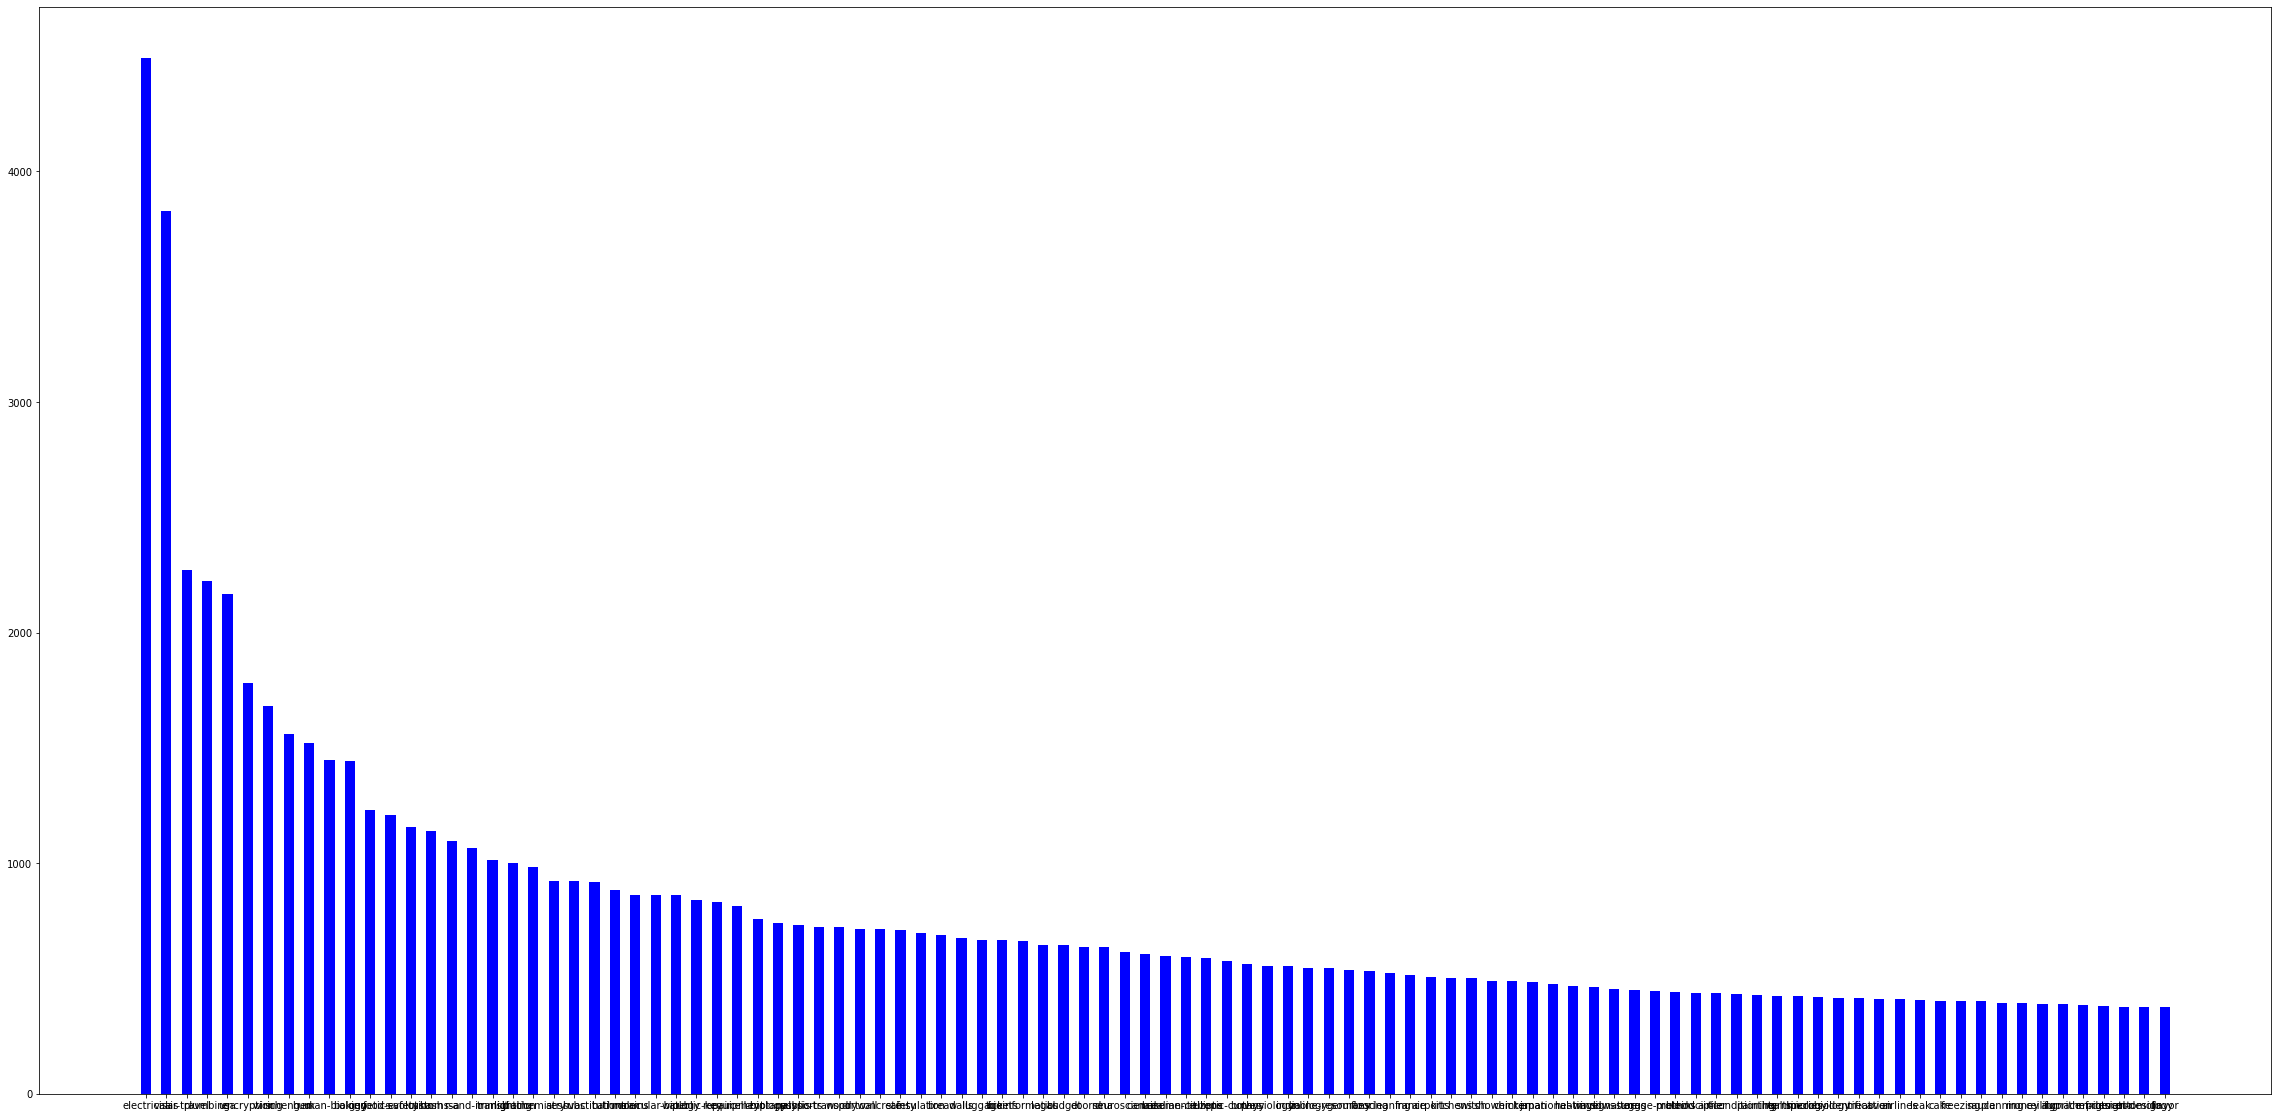

In [ ]:
if os.path.isfile(os.path.join(DATA_DIR, "combined_data.csv")):
    combined_data = pd.read_csv(os.path.join(DATA_DIR, "combined_data.csv"))
    print("combined Data read")

Y = combined_data[["tags"]]

Y["tags"] = Y["tags"].apply(lambda x: x.lower().split(" "))
unique_tags = []
total_tags = []
for _, row in Y.iterrows():
    total_tags.extend(list(row["tags"]))
    if len(unique_tags) == 0:
        unique_tags = set(row["tags"])
    else:
        unique_tags = unique_tags.union(set(row["tags"]))
number_of_unique_tags = len(unique_tags)
print("Total number of unique tags: {}".format(number_of_unique_tags))
tags_count = collections.Counter(total_tags)
most_common_tags = {i[0]:i[1] for i in tags_count.most_common(100)}
print("Most Common 100 Tags are: ")
pprint(most_common_tags)
import matplotlib.pyplot as plt
plt.figure(figsize=(40, 20))
plt.bar(most_common_tags.keys(), most_common_tags.values(), color='b', width=0.5)
plt.show()

del unique_tags
del tags_count
del most_common_tags

**Reducing the dimentionality of target tags**

As we can see above that the target is very sparse matrix, so will do following processing on target tags


As we can see that the target matrix is very sparse because of some tags which are occurring with very less frequency. So lets combine those rare tags and make a new tag "rare". 

P.S. We need to do post processing on the results based on a probability based model , Explained in part2.

In [ ]:
counter_dict = {}
for tag in total_tags:
    if tag not in counter_dict:
        counter_dict[tag] = 1
    else:
        counter_dict[tag] += 1

rare_tags = []
for key, val in counter_dict.items():
    if val<=500:
        rare_tags.append(key)

from copy import deepcopy
def remove_rare_tags(tags):
    temp_tags = deepcopy(tags)
    is_rare = False
    for tag in temp_tags:
        if tag in rare_tags:
            is_rare = True
            tags.remove(tag)
    if is_rare:
        tags.append("rare")
    return tags

print("Number of rare tags seen: {}".format(len(rare_tags)))

Y["tags"] = Y["tags"].apply(remove_rare_tags)

Number of rare tags seen: 4203


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Model Building

**Calculate weight1 and weight0**

As Target martix is very sparse so need to give more weight to 1's else model wont be able to learn with given target.
Hence calculating the weight1 and weight0 

In [ ]:
import numpy as np
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(Y["tags"])
print(y.shape)
print(np.count_nonzero(y))
print(y.shape[0]*y.shape[1])
weight0 = np.count_nonzero(y)/(y.shape[0]*y.shape[1])
weight1 = 1-weight0
print("weight1: {}, weight0: {}".format(weight1, weight0))
del y

(87000, 66)
142964
5742000
weight1: 0.9751020550330896, weight0: 0.024897944966910484


**Define Weighted Binary Cross Entropy**

In [ ]:
def wbce( y_true, y_pred, weight1=0.9, weight0=0.1 ) :
    y_true = K.clip(y_true, K.epsilon(), 1-K.epsilon())
    y_pred = K.clip(y_pred, K.epsilon(), 1-K.epsilon())
    logloss = -(y_true * K.log(y_pred) * weight1 + (1 - y_true) * K.log(1 - y_pred) * weight0 )
    return K.mean( logloss, axis=-1)


**Model Architecture**
Decided the model architeture to be as follows:

Input_text_tokes_with_padding->Embedding_Layer->Conv1D->MaxPool1D->Dropout->Conv1D->MaxPool1D->Dropout->Flatten->Dense->Dropout->Dense->Dropout->Dense

**Loss Function:**
WeightedBinaryCrossEntropy(as defined above)

Binarized the tags.......
vocab_size: 167055
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2582)]            0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 2582, 100)         16705500  
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 2576, 256)         179456    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 257, 256)          0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 257, 256)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 253, 128)          163968    
_________________________________________________________________
max_pooling1d_

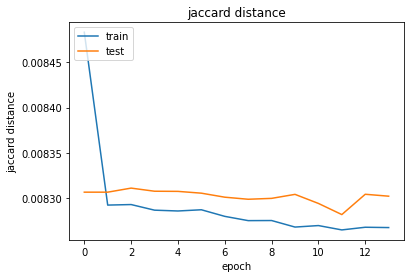

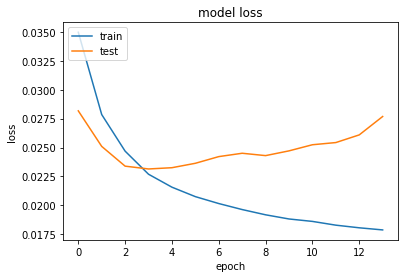

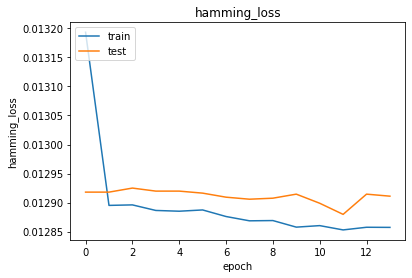

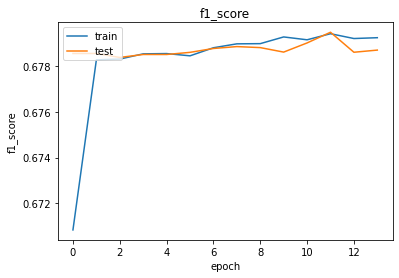

In [ ]:
#Extract X and Y
X = combined_data[["title_content"]]

#Convert tags in to vector of binaries
mlb = MultiLabelBinarizer()
Y_bin = mlb.fit_transform(Y["tags"])
print("Binarized the tags.......")

#treating X
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(X["title_content"])
max_length = max([len(s.split()) for s in X["title_content"]])
vocab_size = len(tokenizer_obj.word_index)+1
print("vocab_size: {}".format(vocab_size))
title_content_tokens = tokenizer_obj.texts_to_sequences(X["title_content"])
title_content_token_len = [len(i) for i in title_content_tokens]
title_content_tokens_pad = pad_sequences(title_content_tokens, maxlen=max_length, padding='pre')

#model train
early_stop_callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(out_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
Embedding_dim=100
timestep = math.floor(statistics.mean(title_content_token_len))

#create model
model_input = Input(shape=(max_length,))
model = Embedding(vocab_size, Embedding_dim, input_length=max_length)(model_input)
model = Convolution1D(filters=256, kernel_size=7, activation='relu')(model)
model = MaxPooling1D(pool_size=10)(model)
model = Dropout(0.2)(model)
model = Convolution1D(filters=128, kernel_size=5, activation='relu')(model)
model = MaxPooling1D(pool_size=5)(model)
model = Dropout(0.2)(model)
model = Flatten()(model)
model = Dense(500, activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(100, activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(Y_bin.shape[1])(model)
# model = BatchNormalization()(model)
out = Activation('sigmoid')(model)
model = Model([model_input], [out])

model.compile(loss = wbce, optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics = [micro_f1_score, hamming_loss, jaccard_distance])
print(model.summary())
model_history = model.fit([title_content_tokens_pad], y=Y_bin, validation_split=0.2, batch_size=128, epochs=30,  callbacks=[early_stop_callback])
model.save(os.path.join(DATA_DIR, 'stackExchange_tags_model_Adam.h5'))

import matplotlib.pyplot as plt
# summarize history for accracy
plt.plot(model_history.history['jaccard_distance'])
plt.plot(model_history.history['val_jaccard_distance'])
plt.title('jaccard distance')
plt.ylabel('jaccard distance')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(os.path.join(DATA_DIR, "jaccard_distance.png"))
plt.close()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(os.path.join(DATA_DIR, "loss.png"))
plt.close()

plt.plot(model_history.history['hamming_loss'])
plt.plot(model_history.history['val_hamming_loss'])
plt.title('hamming_loss')
plt.ylabel('hamming_loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(os.path.join(DATA_DIR, "hamming_loss.png"))
plt.close()

plt.plot(model_history.history['micro_f1_score'])
plt.plot(model_history.history['val_micro_f1_score'])
plt.title('f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(os.path.join(DATA_DIR, "micro_f1_score.png"))
plt.close()


# Post Processing and Future work

**Please refer to Part 2 for result post processing and Future work**